
- Applying model and Gridsearch


In [1]:
import glob
from os import getcwd
import os
import pickle 
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow_addons.metrics import RSquare
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Dropout

In [4]:
# get working directory
path = os.path.dirname(getcwd())
os.chdir(path)

In [5]:
with open("data/full_features/manual-pick/traindt-tf.pkl", 'rb') as f:
   xtrain_tf, ytrain_tf =  pickle.load(file = f)
with open("data/full_features/manual-pick/testdt-tf.pkl", 'rb') as f:
   xtest_tf, ytest_tf =  pickle.load(file = f)
with open("data/full_features/manual-pick/testdt.pkl", 'rb') as f:
   _, ytest =  pickle.load(file = f)

In [6]:
xtrain_tf.shape, ytrain_tf.shape, xtest_tf.shape, ytest_tf.shape, ytest.shape

((738, 52), (738,), (104, 52), (104,), (104, 1))

Set up experiment, Spliting data


In [7]:
import logging
import random
logging.getLogger('tensorflow').disabled = True 
seed = 12345

In [8]:
# spliting data to visualize chosen networks
random.seed(seed)
xtrain_, xval_, ytrain_, yval_ = train_test_split(xtrain_tf, ytrain_tf, test_size=0.20, random_state=42)

In [9]:
xval_.shape, yval_.shape

((148, 52), (148,))

In [10]:
xtrain_.shape, ytrain_.shape

((590, 52), (590,))

Get measure functions, summary Grid results


In [11]:
def summaryGridresult(grid_result, tablename, printrow=6):
   print(tablename)
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   res_tab = pd.DataFrame(grid_result.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
   res_tab = res_tab[['params','mean_train_score','std_test_score','mean_test_score','std_test_score']]
   return res_tab[:printrow]

## Model implementation


### Neural Networks


GridSearch

- MLP
- LSTM
- ARIMA


In [12]:
# make scorer for Gridsearch
#r2_scorer = make_scorer(r2_score)

In [13]:
# Building plot function 

def plot_history(model_hist, expname, epochs =200):
    res = pd.DataFrame(model_hist.history)
    res_dic = {'loss - MSE':{'train':res['loss'], 'val':res['val_loss']},
                'r2': {'train':res['r_square'], 'val':res['val_r_square']}}
    x = range(1, epochs+1)
    fig, ax = plt.subplots(ncols = 2, figsize = [15,5])
    measures = list(res_dic.keys())
    for i, m in enumerate(measures):
        ax[i].plot(x, res_dic[m]['train'], label = f'training{m}')
        ax[i].plot(x, res_dic[m]['val'], label = f'training{m}')
        ax[i].set_ylabel(measures[i])   
        ax[i].set_title(f'Training and validation {m} {expname}')
        ax[i].legend(['training', 'validation'])
        ax[i].grid(visible=True)
    plt.xlabel('Epochs')
    plt.show()

In [14]:
#plot comparation

def plot_comparation(data_list, label_list, title, ylabel, epochrange):
    epochs = range(epochrange[0]+1, epochrange[1]+1)
    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data[epochrange[0]: epochrange[1]], label=label)
    plt.title(title)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [15]:
# Plot prediction
%matplotlib inline
def plotprediction(true, pred, modelname):
    pred_table = pd.DataFrame({'preds': pred}, index = true.index)
    prediction_table = true.join(pred_table)
    prediction_table = prediction_table.rename(columns = {'sales': 'true'})
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(prediction_table['true'], label='Truth')
    ax.plot(prediction_table['preds'], label='Prediction')
    ax.set_title('Comparing prediction from {}'.format(modelname), fontsize=20)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Sales', fontsize=16)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    leg = ax.legend(fontsize = 18)

In [16]:
def get_best_epochs(model_hist):
   model_loss = model_hist.history["val_loss"]
   epoch_chosen = model_loss.index(min(model_loss)) +1
   print(f'Best number of epochs {epoch_chosen}')

In [17]:
# precision
def get_pre(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true[i] == 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/true[i] <= threshold:
                TP +=1
    return TP/len(true)

MLP


In [18]:
# Finding the best Number of hidden layers
mlp_gridlayers = {'hidden_layer_sizes': [(64, 8),
                                         (64, 16, 8),
                                         (128, 16, 8),
                                         (128, 32, 8),
                                         (128, 64, 8),
                                         (128, 64, 16),
                                         (128, 64, 16, 8),
                                         (256, 128, 16, 8),
                                         (256, 128, 32, 8),
                                         (256, 128, 64, 8),
                                         (256, 128, 64, 16),
                                         (256, 128, 64, 32),
                                         (128, 128, 128, 64, 16),
                                         (256, 128, 128, 64, 8),
                                         (256, 256, 128, 128, 64),
                                         (256, 128, 64, 16, 8),
                                         (256, 128, 64, 32, 8),
                                         (256, 128, 64, 32, 16),
                                         (256, 128, 64, 64, 8),
                                         (256, 128, 64, 64, 16),
                                         (256, 128, 64, 32, 16, 8),]}

random.seed(seed)
mlp = MLPRegressor(max_iter=200, early_stopping=True)  # default by the rest
grid_layers = GridSearchCV(mlp, mlp_gridlayers, cv=4,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_result_layer = grid_layers.fit(xtrain_tf, ytrain_tf)
summaryGridresult(grid_result_layer, 'Best results for Hidden layers structures', 10)


Best results for Hidden layers structures
Best: 0.664863 using {'hidden_layer_sizes': (256, 128, 64, 64, 8)}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
18,"{'hidden_layer_sizes': (256, 128, 64, 64, 8)}",0.796715,0.041119,0.664863,0.041119
8,"{'hidden_layer_sizes': (256, 128, 32, 8)}",0.809175,0.040193,0.664819,0.040193
15,"{'hidden_layer_sizes': (256, 128, 64, 16, 8)}",0.833037,0.028622,0.664578,0.028622
20,"{'hidden_layer_sizes': (256, 128, 64, 32, 16, 8)}",0.778212,0.034012,0.655391,0.034012
14,"{'hidden_layer_sizes': (256, 256, 128, 128, 64)}",0.773991,0.036652,0.653498,0.036652
12,"{'hidden_layer_sizes': (128, 128, 128, 64, 16)}",0.811736,0.039545,0.652087,0.039545
1,"{'hidden_layer_sizes': (64, 16, 8)}",0.794864,0.025210,0.649872,0.025210
10,"{'hidden_layer_sizes': (256, 128, 64, 16)}",0.826270,0.016128,0.648588,0.016128
19,"{'hidden_layer_sizes': (256, 128, 64, 64, 16)}",0.793366,0.042102,0.648276,0.042102
17,"{'hidden_layer_sizes': (256, 128, 64, 32, 16)}",0.781925,0.038189,0.646158,0.038189


In [19]:
# Build baseline network with Keras
#network = [256, 128, 64, 16, 8]
#kernel_init = 'uniform'
#acti = 'relu'
#opt = 'adam'
chosennetwork = grid_result_layer.best_params_['hidden_layer_sizes']
n_feat = xtrain_tf.shape[1]
def create_mlpbl():
   network = chosennetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = 'uniform', 
                  activation='relu' , input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = 'relu'))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model
#network = np.array([256, 128, 64, 16])
mlpbl = create_mlpbl()
mlpbl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               13568     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 59,409
Trainable params: 59,409
Non-traina

In [20]:
tf.random.set_seed(seed)
random.seed(seed)
mlpbl = create_mlpbl()
mlpbl_hist = mlpbl.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=128,
                      validation_data=(xval_, yval_),
                      verbose=0)

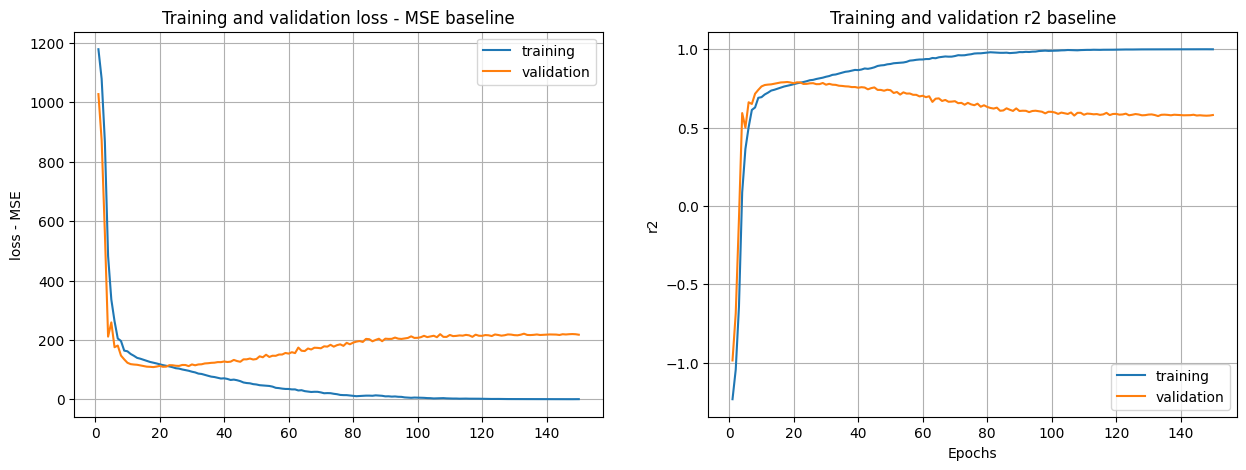

In [21]:
plot_history(mlpbl_hist,'baseline',150)

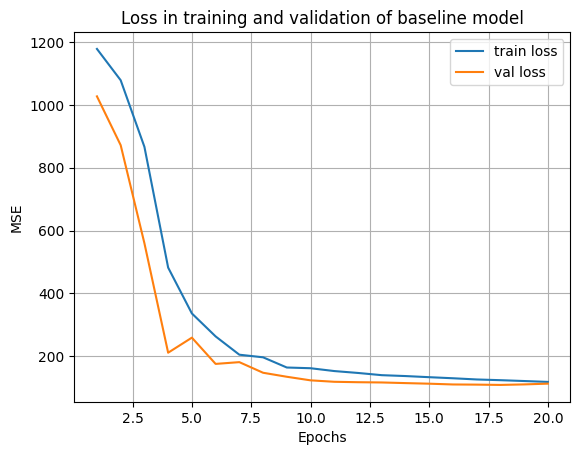

In [22]:
loss_train = mlpbl_hist.history['loss']
loss_val = mlpbl_hist.history['val_loss']


plot_comparation(data_list=[loss_train,loss_val], 
               label_list=['train loss', 'val loss'],
               title='Loss in training and validation of baseline model',
               ylabel='MSE',
               epochrange=(0,20))

In [23]:
get_best_epochs(mlpbl_hist)

Best number of epochs 18


### choose batch size

In [24]:
# default params as baseline

# Grid params
batch_size = np.array([8, 16, 32, 64, 128])
epochs = np.arange(0,30)
batch_pams = dict(batch_size=batch_size, epochs=epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)

mlp = KerasRegressor(model=create_mlpbl, verbose=0)
grid_batch = GridSearchCV(mlp, batch_pams, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_batch = grid_batch.fit(xtrain_tf, ytrain_tf)
summaryGridresult(grid_result_batch, 'Top batch-sizes by epochs', 10)


c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top batch-sizes by epochs
Best: 0.674538 using {'batch_size': 64, 'epochs': 15}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
105,"{'batch_size': 64, 'epochs': 15}",0.787006,0.029909,0.674538,0.029909
138,"{'batch_size': 128, 'epochs': 18}",0.781702,0.037594,0.674497,0.037594
104,"{'batch_size': 64, 'epochs': 14}",0.790605,0.034014,0.672929,0.034014
37,"{'batch_size': 16, 'epochs': 7}",0.810825,0.042871,0.672487,0.042871
69,"{'batch_size': 32, 'epochs': 9}",0.782491,0.032678,0.672337,0.032678
149,"{'batch_size': 128, 'epochs': 29}",0.816407,0.040966,0.669232,0.040966
110,"{'batch_size': 64, 'epochs': 20}",0.830805,0.038045,0.667798,0.038045
145,"{'batch_size': 128, 'epochs': 25}",0.788189,0.034076,0.667585,0.034076
108,"{'batch_size': 64, 'epochs': 18}",0.816655,0.030111,0.667487,0.030111
102,"{'batch_size': 64, 'epochs': 12}",0.780889,0.038396,0.666513,0.038396


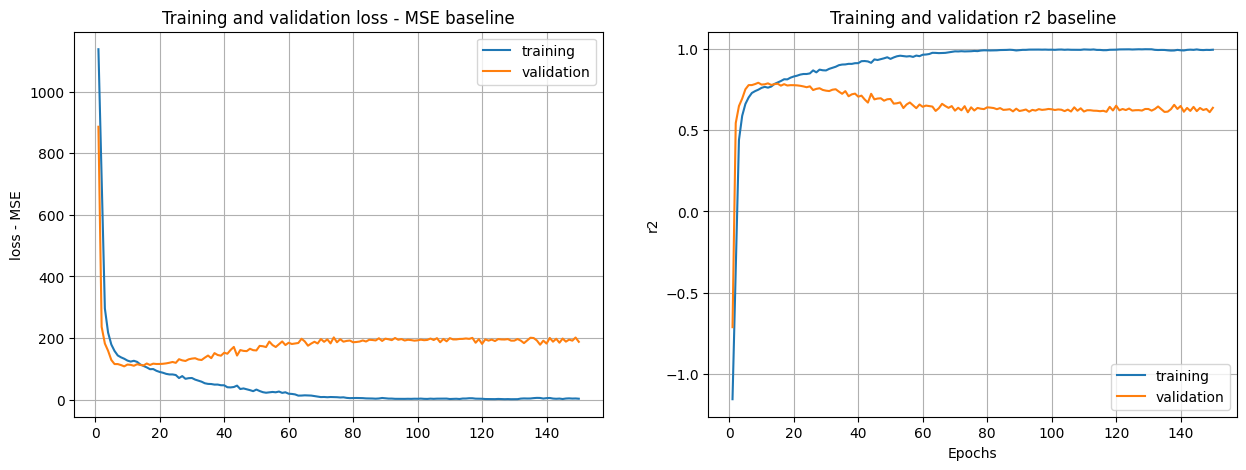

In [25]:
chosenBatch = grid_result_batch.best_params_['batch_size']
tf.random.set_seed(seed)
random.seed(seed)
mlp = create_mlpbl()
mlpbl_hist = mlp.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlpbl_hist,'baseline',150)

In [26]:
get_best_epochs(mlpbl_hist)

Best number of epochs 9


### Kernel initializer

In [27]:
### Kernel initializer

def create_mlpk(k_init = 'uniform'):
   network = chosennetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = k_init, 
                  activation='relu', input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = 'relu'))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
k_init = ['uniform', 'normal', 'glorot_normal', 'glorot_uniform', ]
epochs = np.arange(0,30)

pams_grid = dict(model__k_init= k_init,  
               epochs = epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)
mlp = KerasRegressor(model = create_mlpk,
                     batch_size = chosenBatch,
                     verbose=0)
grid_kn = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_kn = grid_kn.fit(xtrain_tf, ytrain_tf)


pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_kn, 'Top results for inititalization' , 10)


Top results for inititalization
Best: 0.678394 using {'epochs': 18, 'model__k_init': 'glorot_uniform'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
75,"{'epochs': 18, 'model__k_init': 'glorot_uniform'}",0.819854,0.035117,0.678394,0.035117
61,"{'epochs': 15, 'model__k_init': 'normal'}",0.807249,0.035380,0.675816,0.035380
69,"{'epochs': 17, 'model__k_init': 'normal'}",0.811282,0.032366,0.674892,0.032366
66,"{'epochs': 16, 'model__k_init': 'glorot_normal'}",0.823644,0.027408,0.674631,0.027408
87,"{'epochs': 21, 'model__k_init': 'glorot_uniform'}",0.851113,0.027974,0.674424,0.027974
53,"{'epochs': 13, 'model__k_init': 'normal'}",0.786003,0.038505,0.674140,0.038505
56,"{'epochs': 14, 'model__k_init': 'uniform'}",0.791562,0.036092,0.673999,0.036092
73,"{'epochs': 18, 'model__k_init': 'normal'}",0.827447,0.040256,0.673715,0.040256
63,"{'epochs': 15, 'model__k_init': 'glorot_uniform'}",0.802628,0.040668,0.672707,0.040668
54,"{'epochs': 13, 'model__k_init': 'glorot_normal'}",0.794335,0.030860,0.672432,0.030860


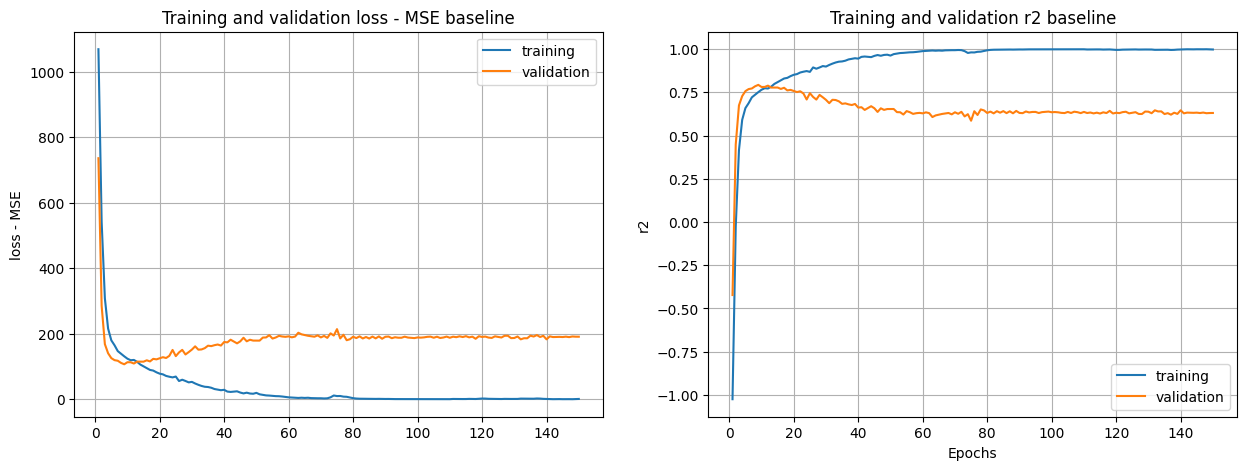

In [28]:
chosenKn = grid_result_kn.best_params_['model__k_init']
tf.random.set_seed(seed)
random.seed(seed)
mlp_kn = create_mlpk(chosenKn)
mlp_kn_hist = mlp_kn.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_kn_hist,'baseline',150)

In [29]:
get_best_epochs(mlp_kn_hist)

Best number of epochs 9


### activation funtion

In [30]:
# model default params for assessing activation and kernel initialization
# network = [256, 128, 64, 16, 8]
# batch size = 128
# opt = 'adam'

def create_mlpa(acti = 'relu'):
   network = chosennetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=acti, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = acti))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
acti = ['relu','selu','elu', 'tanh', 'sigmoid']
epochs = np.arange(0,30)

pams_grid = dict(model__acti = acti, 
               epochs = epochs)

# Build model and grid search
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model = create_mlpa,
                     batch_size = chosenBatch,
                     verbose=0)
grid_a = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_a = grid_a.fit(xtrain_tf, ytrain_tf)
pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_a, 'Top results for activation' , 10)

Top results for activation
Best: 0.688320 using {'epochs': 17, 'model__acti': 'elu'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
87,"{'epochs': 17, 'model__acti': 'elu'}",0.802810,0.030640,0.688320,0.030640
142,"{'epochs': 28, 'model__acti': 'elu'}",0.838465,0.018743,0.687636,0.018743
82,"{'epochs': 16, 'model__acti': 'elu'}",0.800483,0.018587,0.685716,0.018587
147,"{'epochs': 29, 'model__acti': 'elu'}",0.834951,0.031710,0.684685,0.031710
102,"{'epochs': 20, 'model__acti': 'elu'}",0.815307,0.029377,0.683640,0.029377
92,"{'epochs': 18, 'model__acti': 'elu'}",0.802243,0.022133,0.683306,0.022133
137,"{'epochs': 27, 'model__acti': 'elu'}",0.840444,0.030439,0.680781,0.030439
85,"{'epochs': 17, 'model__acti': 'relu'}",0.824444,0.036216,0.680347,0.036216
122,"{'epochs': 24, 'model__acti': 'elu'}",0.819988,0.032505,0.679824,0.032505
97,"{'epochs': 19, 'model__acti': 'elu'}",0.807031,0.028460,0.679202,0.028460


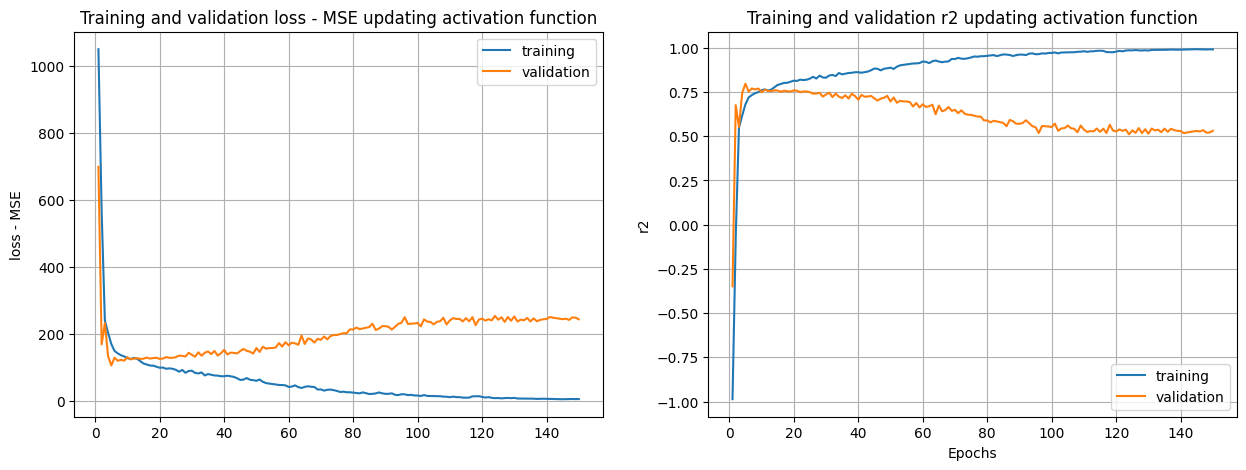

In [31]:
chosenActi = grid_result_a.best_params_['model__acti']
tf.random.set_seed(seed)
random.seed(seed)
mlp_a = create_mlpa(chosenActi)
mlp_a_hist = mlp_a.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_a_hist,'updating activation function',150)

In [32]:
get_best_epochs(mlp_a_hist)

Best number of epochs 5


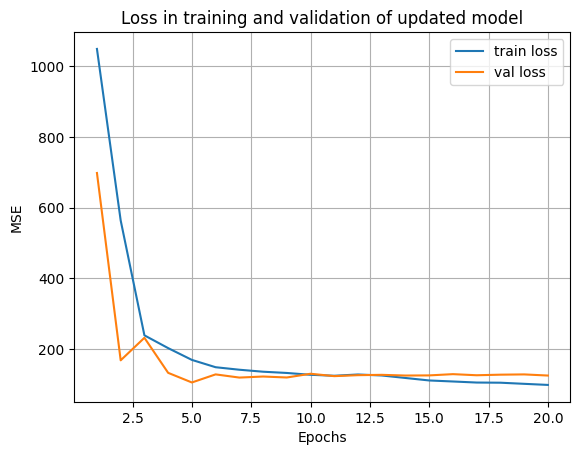

In [33]:
loss_train = mlp_a_hist.history['loss']
loss_val = mlp_a_hist.history['val_loss']


plot_comparation(data_list=[loss_train,loss_val], 
               label_list=['train loss', 'val loss'],
               title='Loss in training and validation of updated model',
               ylabel='MSE',
               epochrange=(0,20))

### Selecting optimizer

In [34]:
# model default params for assessing optimization
# network = [256, 128, 64, 16]
# batch size = 128
# acti = 'selu' / kernel_init = 'uniform' 
def create_mlpopt(opt = 'Adam'):
   network = chosennetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
   model.add(Dense(1))
   model.compile(optimizer=opt, 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
opt = ['SGD', 'RMSprop', 'Adam']
epochs = np.arange(0,30)
pams_grid = dict(model__opt =opt, 
                  epochs = epochs)

# Build model and grid searcg
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model=create_mlpopt,
                     batch_size = chosenBatch,
                     verbose=0)
grid_opt = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_opt = grid_opt.fit(xtrain_tf, ytrain_tf)
summaryGridresult(grid_result_opt, 'Top resutls for optimizer' , 10)

c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-1.53217763 -1.51701987 -1.53723679         nan -0.64087678 -1.31026652
         nan  0.21847726 -0.60554663         nan  0.53705069 -0.26374642
         nan  0.56009852  0.07083958         nan  0.59547785  0.61297853
         nan  0.64593629  0.61117804         nan  0.64485417  0.64850219
         nan  0.64747979  0.6564846          nan  0.67597988  0.65211611
         nan  0.66878749  0.64622266         nan  0.68046539  0.66558141
         nan  0.67598068  0.66503562         nan  0.64701127  0.66985309
         nan  0.67513602  0.68021507         nan  0.6728718   0.67454571
         nan  0.67655426  0.66765374         nan  0.67561091  0.68232353
         nan  0.67313739  0.68068207         nan  0.64635216  0.67961204
         nan  0.67756612  0.68352103         nan  0.66650547  0.66538349
         nan  0.66727

Top resutls for optimizer
Best: 0.685250 using {'epochs': 24, 'model__opt': 'Adam'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
74,"{'epochs': 24, 'model__opt': 'Adam'}",0.825632,0.027505,0.685250,0.027505
62,"{'epochs': 20, 'model__opt': 'Adam'}",0.812753,0.041594,0.683521,0.041594
53,"{'epochs': 17, 'model__opt': 'Adam'}",0.795656,0.022539,0.682324,0.022539
70,"{'epochs': 23, 'model__opt': 'RMSprop'}",0.820714,0.036040,0.682321,0.036040
80,"{'epochs': 26, 'model__opt': 'Adam'}",0.822784,0.022175,0.682137,0.022175
56,"{'epochs': 18, 'model__opt': 'Adam'}",0.797993,0.029917,0.680682,0.029917
34,"{'epochs': 11, 'model__opt': 'RMSprop'}",0.771376,0.022038,0.680465,0.022038
44,"{'epochs': 14, 'model__opt': 'Adam'}",0.788491,0.022529,0.680215,0.022529
59,"{'epochs': 19, 'model__opt': 'Adam'}",0.814133,0.027721,0.679612,0.027721
77,"{'epochs': 25, 'model__opt': 'Adam'}",0.821815,0.033766,0.679245,0.033766


#### Learning rate

In [35]:
chosenOpt = grid_result_opt.best_params_['model__opt']

def create_mlplr():
   network = chosennetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = chosenActi))
   model.add(Dense(1))
   model.compile(optimizer=chosenOpt,
               loss='mse', metrics=[RSquare()])
   return model

lr = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075]
epochs = np.arange(0,30)
pams_grid = dict(model__optimizer__learning_rate=lr,
                  epochs = epochs)


# Build model and grid search
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model = create_mlplr,
                     batch_size = chosenBatch,
                     verbose=0)
grid_lr = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1,)
                        
grid_result_lr = grid_lr.fit(xtrain_tf, ytrain_tf)

pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_lr, 'Top results for learning rate' , 10)

c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top results for learning rate
Best: 0.692279 using {'epochs': 17, 'model__optimizer__learning_rate': 0.0025}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
123,"{'epochs': 17, 'model__optimizer__learning_rate': 0.0025}",0.796945,0.022377,0.692279,0.022377
164,"{'epochs': 23, 'model__optimizer__learning_rate': 0.001}",0.824339,0.035695,0.687994,0.035695
175,"{'epochs': 25, 'model__optimizer__learning_rate': 0.00025}",0.830415,0.032400,0.687622,0.032400
170,"{'epochs': 24, 'model__optimizer__learning_rate': 0.00075}",0.824772,0.030156,0.687531,0.030156
161,"{'epochs': 23, 'model__optimizer__learning_rate': 0.00025}",0.826453,0.034198,0.687466,0.034198
167,"{'epochs': 23, 'model__optimizer__learning_rate': 0.0075}",0.823760,0.032061,0.687137,0.032061
200,"{'epochs': 28, 'model__optimizer__learning_rate': 0.0025}",0.829144,0.038047,0.687073,0.038047
142,"{'epochs': 20, 'model__optimizer__learning_rate': 0.00075}",0.813313,0.025295,0.685416,0.025295
182,"{'epochs': 26, 'model__optimizer__learning_rate': 0.00025}",0.831700,0.042599,0.685323,0.042599
177,"{'epochs': 25, 'model__optimizer__learning_rate': 0.00075}",0.830049,0.031700,0.685099,0.031700


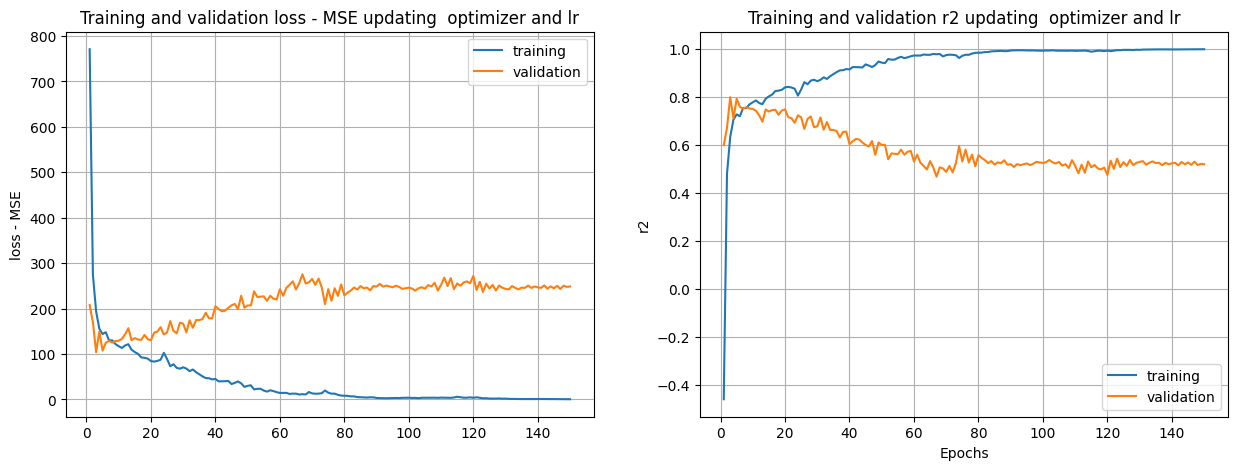

In [39]:
# Visualize
chosenLr = grid_result_lr.best_params_['model__optimizer__learning_rate']
def create_mlplr(lr = chosenLr):
   network = chosennetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = chosenActi))
   model.add(Dense(1))
   opt = tf.optimizers.Adam(learning_rate=lr)
   model.compile(optimizer=opt,
               loss='mse', metrics=[RSquare()])
   return model

tf.random.set_seed(seed)
random.seed(seed)
mlp_lr =  create_mlplr()
mlp_lr_hist= mlp_lr.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)

plot_history(mlp_lr_hist,'updating  optimizer and lr',150)

In [40]:
get_best_epochs(mlp_lr_hist)

Best number of epochs 3


### Drop-out

In [68]:
# Drop oout
def create_mlpdpt(dpt = 0):
   network = chosennetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   model.add(Dropout(dpt))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
      model.add(Dropout(dpt))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate=chosenLr)
   model.compile(optimizer = opt, 
               loss='mse', metrics=[RSquare()])
   return model
#Buil Learning rate for optimization function
dpt = np.array([0, 0.1,0.2, 0.3, 0.4, 0.5])
epochs = np.arange(0,30)

pams_grid = dict(model__dpt=dpt,
                  epochs = epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)
mlp = KerasRegressor(model=create_mlpdpt,
                     batch_size = chosenBatch,
                     verbose=0)
grid_dpt = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_dpt = grid_dpt.fit(xtrain_tf, ytrain_tf)
pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_dpt, 'Top results for learning rate' , 10)

c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top results for learning rate
Best: 0.684848 using {'epochs': 13, 'model__dpt': 0.0}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
78,"{'epochs': 13, 'model__dpt': 0.0}",0.806943,0.034687,0.684848,0.034687
72,"{'epochs': 12, 'model__dpt': 0.0}",0.794151,0.030749,0.681253,0.030749
140,"{'epochs': 23, 'model__dpt': 0.2}",0.813616,0.030539,0.680970,0.030539
158,"{'epochs': 26, 'model__dpt': 0.2}",0.807019,0.033705,0.680810,0.033705
54,"{'epochs': 9, 'model__dpt': 0.0}",0.781861,0.031089,0.680142,0.031089
60,"{'epochs': 10, 'model__dpt': 0.0}",0.791764,0.029171,0.680091,0.029171
122,"{'epochs': 20, 'model__dpt': 0.2}",0.801847,0.029050,0.678776,0.029050
86,"{'epochs': 14, 'model__dpt': 0.2}",0.779031,0.028208,0.678329,0.028208
66,"{'epochs': 11, 'model__dpt': 0.0}",0.798239,0.046609,0.676634,0.046609
91,"{'epochs': 15, 'model__dpt': 0.1}",0.789639,0.038414,0.676157,0.038414


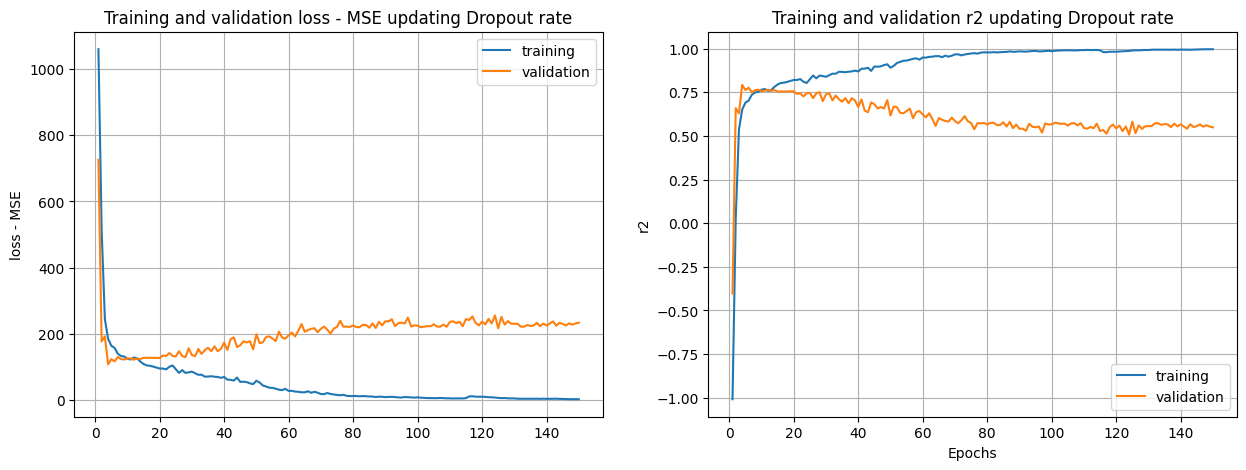

In [69]:
# visualize
chosenDr = grid_result_dpt.best_params_['model__dpt']
mlp_dpt =  create_mlpdpt( dpt= chosenDr)
mlp_dpt_hist= mlp_dpt.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_dpt_hist, 'updating Dropout rate', 150)


In [70]:
get_best_epochs(mlp_dpt_hist)

Best number of epochs 4


### Final model

In [ ]:
chosenEp = grid_result_dpt.best_params_['epochs']
tf.random.set_seed(seed)
random.seed(seed)
mlp_final = create_mlpdpt( dpt= chosenDr)
mlp_final.fit(xtrain_tf, ytrain_tf,
               epochs=16,
               batch_size=chosenBatch,
               verbose=0,)


In [ ]:
test_lost_score, test_r2_score = mlp_final.evaluate(xtest_tf, ytest_tf)
test_pred = mlp_final.predict(xtest_tf)

4/4 [==============================] - 0s 1ms/step


MSE in testing: 128.26612854003906, 
R2 in testing: 0.7659568786621094,
MAE in testing: 7.611699770919691, 
Precision of 10%: 0.5288461538461539,
Precision of 20%: 0.6730769230769231,
Precision of 300%: 0.7596153846153846


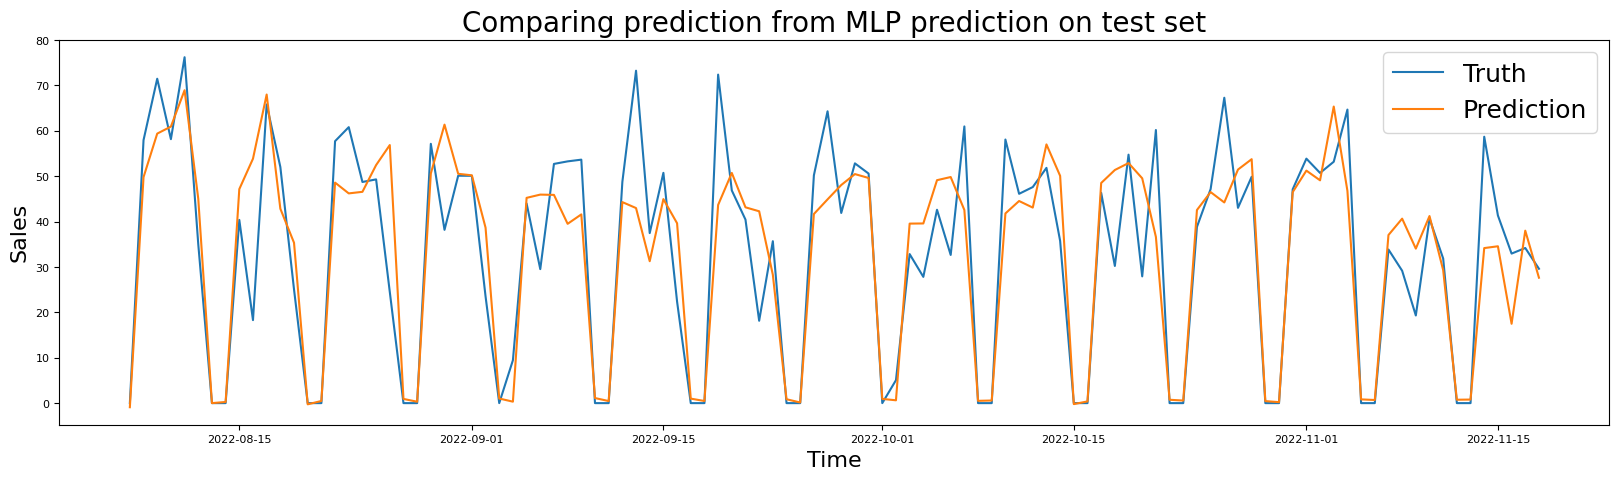

In [ ]:

mae =  mean_absolute_error(ytest_tf, test_pred)
pre = get_pre(ytest_tf, test_pred, 0.1)

print(f'MSE in testing: {test_lost_score}, \nR2 in testing: {test_r2_score},\nMAE in testing: {mae}, \nPrecision of 10%: {pre},\nPrecision of 20%: {get_pre(ytest_tf, test_pred, 0.2)},\nPrecision of 300%: {get_pre(ytest_tf, test_pred, 0.3)}')

plotprediction(ytest, test_pred.flatten(), 'MLP prediction on test set')